<h1>Part 1: data preprocessing and cleaning<h1>

In [3]:
import pandas as pd
import emoji
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from symspellpy import SymSpell, Verbosity
from sklearn.model_selection import train_test_split
import swifter
import spacy
from spacy.cli import download
from langdetect import detect
import importlib.resources
import matplotlib.pyplot as plt
import seaborn as sns

**Step 1: loading, splitting and exploring the data set**

"The DataSet consists of user reviews of ChatGPT, including Textual Feedback, Ratings, and Review Dates. The Reviews Range from brief comments to more detailed feedback by covering a wide range of user sentiments. The ratings are on a scale of 1 to 5, representing varying levels of Satisfaction. The dataset spans multiple months, providing a temporal dimension for analysis. Each review is accompanied by a timestamp, allowing for Time-Series analysis of sentiment trends."

source: https://www.kaggle.com/datasets/anandshaw2001/chatgpt-users-reviews

In [4]:
df = pd.read_csv("ChatGPT_Reviews.csv")

train_df, val_df = train_test_split(df, test_size=0.3, random_state=2092)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")

train_df.to_csv("train.csv", index=False)
val_df.to_csv("val.csv", index=False)

Training set size: 137708
Validation set size: 59019


In [5]:
df = pd.read_csv("train.csv")
df.head()

,Review Id,Review,Ratings,Review Date
0,33848fb1-4973-4ffb-b44c-d4a1570a63c5,Aš myliu šita programą! Jie nupiešė man kate. 😊😺,5,12/23/2023 10:21
1,97584f06-b675-42cf-8335-72a926d36665,I need the other are free,5,4/10/2024 3:33
2,ff058dc6-b6ec-4f21-959e-d3a4f1265ab5,best Used to find answer to do home work yohh ...,5,7/26/2024 11:32
3,a5791b2c-ce75-4f2b-baeb-96ce61c03fd4,wonderful,5,3/23/2024 6:38
4,6471363b-6f88-4e69-bcdb-7c6f7eda8d42,Very useful,5,3/22/2024 6:54


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137708 entries, 0 to 137707
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Review Id    137708 non-null  object
 1   Review       137704 non-null  object
 2   Ratings      137708 non-null  int64 
 3   Review Date  137708 non-null  object
dtypes: int64(1), object(3)
memory usage: 4.2+ MB


In [7]:
df = df.drop_duplicates(subset='Review Id', keep='first')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 135682 entries, 0 to 137707
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Review Id    135682 non-null  object
 1   Review       135678 non-null  object
 2   Ratings      135682 non-null  int64 
 3   Review Date  135682 non-null  object
dtypes: int64(1), object(3)
memory usage: 5.2+ MB


We removed 137708 - 135682 = 2026 duplicates. Moreover, we observe 4 missing reviews and we subsequently drop them from the dataframe, but beforehand we check the distribution of df["Ratings"],
so that we have a reference when preprocessing is complete.

**Plotting the ratings**

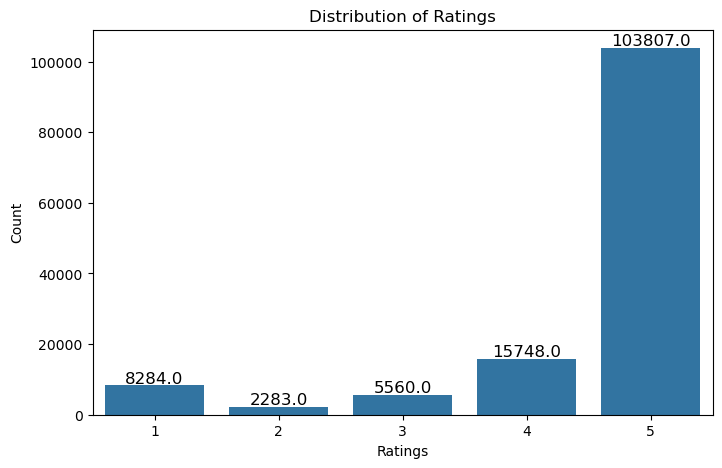

In [8]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(x=df['Ratings'])

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=12, color='black', 
                xytext=(0, 5), textcoords='offset points')

plt.title('Distribution of Ratings')
plt.xlabel('Ratings')
plt.ylabel('Count')

plt.show()

**Dropping the missing reviews**

In [9]:
df = df.dropna()

**Step 2: removing non-English reviews**

In [10]:
def is_english(text):
    try:
        return detect(text) == "en"
    except:
        return False

df = df[df["Review"].swifter.apply(is_english)]

Pandas Apply:   0%|          | 0/135678 [00:00<?, ?it/s]

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 81245 entries, 1 to 137707
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Review Id    81245 non-null  object
 1   Review       81245 non-null  object
 2   Ratings      81245 non-null  int64 
 3   Review Date  81245 non-null  object
dtypes: int64(1), object(3)
memory usage: 3.1+ MB


We have reduced the data frame by 135678 - 81245 = 54433 records

**Step 3: translating emojis to English**

In [13]:
def convert_emojis_to_text(text):
    return emoji.demojize(text, delimiters=(" ", " "))

df["Review"] = df["Review"].apply(convert_emojis_to_text)

**Step 4: converting all reviews to lowercase**

In [14]:
df["Review"] = df["Review"].str.lower()

**Step 5: correcting spelling errors**

In [15]:
dictionary_path = importlib.resources.files("symspellpy") / "frequency_dictionary_en_82_765.txt"

sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)

sym_spell.load_dictionary(str(dictionary_path), term_index=0, count_index=1)

def correct_text(text):
    if isinstance(text, str):  
        suggestion = sym_spell.lookup_compound(text, max_edit_distance=2)
        return suggestion[0].term if suggestion else text
    return text 

df["Review"] = df["Review"].swifter.apply(correct_text)

Pandas Apply:   0%|          | 0/81245 [00:00<?, ?it/s]

**Step 6: removing stop words**

In [12]:
# Run only once!

# nltk.download('stopwords')
# nltk.download('punkt')

In [16]:
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

df["Review"] = df["Review"].apply(remove_stopwords)

**Step 7: lemmatizing the reviews**

In [14]:
# Run only once!
# download("en_core_web_sm")

In [17]:
nlp = spacy.load("en_core_web_sm")

def lemmatize_text(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

df["Review"] = df["Review"].swifter.apply(lemmatize_text)

Pandas Apply:   0%|          | 0/81245 [00:00<?, ?it/s]

**Step 8: removing punctuation**

In [18]:
def remove_punctuation(text):
    text = re.sub(r'[^\w\s]', '', text)
    return text

df["Review"] = df["Review"].apply(remove_punctuation)

**Step 9: checking and comparing the distribution of df["Ratings"]**

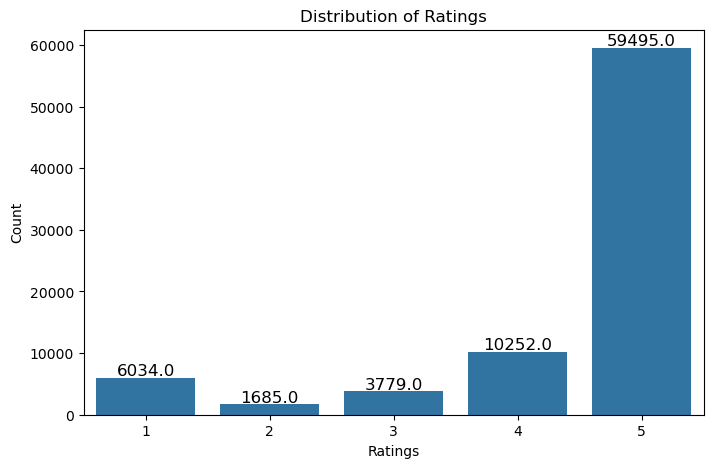

In [19]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(x=df['Ratings'])

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=12, color='black', 
                xytext=(0, 5), textcoords='offset points')

plt.title('Distribution of Ratings')
plt.xlabel('Ratings')
plt.ylabel('Count')

plt.show()

**Ratings of value 1 preserved: 73%** <br>
**Ratings of value 2 preserved: 74%** <br>
**Ratings of value 3 preserved: 68%** <br>
**Ratings of value 4 preserved: 65%** <br>
**Ratings of value 5 preserved: 57%**

**Step 10: saving the cleaned ChatGPT reviews**

In [20]:
df.to_csv("train_cleaned.csv", index=False)